In [1]:
import config
import sqlalchemy
import functions
import statsapi as mlb
import sql_alch_schema
from datetime import datetime

In [2]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,DateTime,Date,Time,Boolean
from sqlalchemy import ForeignKey,and_
from sqlalchemy.orm import relationship
from sqlalchemy.schema import Table
from sqlalchemy import distinct

In [3]:
_sql_alchemy_connection = (
                                f'mysql+mysqlconnector://'
                                f'{config.user}:{config.password}'
                                f'@{config.host}:{config.port}'
                                f'/{config.schema}'
                           )
## Create the engine 
db = sqlalchemy.create_engine(_sql_alchemy_connection,
                              echo = False,
                              connect_args = {'ssl_disabled' : True,})

In [4]:
Base = sql_alch_schema.Base

Game = sql_alch_schema.Game
Play = sql_alch_schema.Play
Team = sql_alch_schema.Team
GameTeamLink = sql_alch_schema.GameTeamLink
Person = sql_alch_schema.Person


from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=db)
session = Session()

In [5]:
Base.metadata.create_all(db)

In [6]:
import sqlalchemy_schemadisplay
from sqlalchemy import MetaData

schema_viz = sqlalchemy_schemadisplay.create_schema_graph(metadata=MetaData(db))
schema_viz.write_png('dbschema.png')

A Game record queried from mysql has a .teams attribute that retuns two GameTeamLink records as shown below

In [7]:
test_gameId = '2019/03/28/anamlb-oakmlb-1'
game_test = session.query(Game).filter_by(id=test_gameId).one()

print(game_test)

<Game(pk='566086',id='2019/03/28/anamlb-oakmlb-1')>


In [8]:
game_test.teams

[<GameTeam(game_id='2019/03/28/anamlb-oakmlb-1',team_id='108')>,
 <GameTeam(game_id='2019/03/28/anamlb-oakmlb-1',team_id='133')>]

In [9]:
play_test = session.query(Play).first()

In [10]:
play_test.batter_id

645277

In [11]:
play_test.game

<Game(pk='533881',id='2018/03/01/atlmlb-detmlb-1')>

A game_team object can access the associated game record and team record as well as plays for that game

In [12]:
game_team_test = game_test.teams[0]

print(game_team_test,'\n')
print(game_team_test.team,'\n')
print(game_team_test.player_1_id,'\n')
game_team_test.game.plays

<GameTeam(game_id='2019/03/28/anamlb-oakmlb-1',team_id='108')> 

<Team(name='Los Angeles Angels')> 

405395 



[<Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='0')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='1')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='10')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='11')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='12')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='13')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='14')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='15')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='16')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='17')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='18')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='19')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='2')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='20')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='21')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='22

In [13]:
team_test = game_team_test.team
team_test

<Team(name='Los Angeles Angels')>

In [14]:
team_test.games

[<GameTeam(game_id='2019/02/23/sfnmlb-anamlb-1',team_id='108')>,
 <GameTeam(game_id='2019/02/24/anamlb-lanmlb-1',team_id='108')>,
 <GameTeam(game_id='2019/02/24/cinmlb-anamlb-2',team_id='108')>,
 <GameTeam(game_id='2019/02/25/milmlb-anamlb-1',team_id='108')>,
 <GameTeam(game_id='2019/02/26/anamlb-oakmlb-1',team_id='108')>,
 <GameTeam(game_id='2019/02/27/anamlb-colmlb-1',team_id='108')>,
 <GameTeam(game_id='2019/02/28/texmlb-anamlb-1',team_id='108')>,
 <GameTeam(game_id='2019/03/01/kcamlb-anamlb-1',team_id='108')>,
 <GameTeam(game_id='2019/03/02/anamlb-cinmlb-1',team_id='108')>,
 <GameTeam(game_id='2019/03/03/oakmlb-anamlb-1',team_id='108')>,
 <GameTeam(game_id='2019/03/04/anamlb-chamlb-1',team_id='108')>,
 <GameTeam(game_id='2019/03/05/chnmlb-anamlb-1',team_id='108')>,
 <GameTeam(game_id='2019/03/06/anamlb-colmlb-1',team_id='108')>,
 <GameTeam(game_id='2019/03/07/anamlb-kcamlb-1',team_id='108')>,
 <GameTeam(game_id='2019/03/07/lanmlb-anamlb-2',team_id='108')>,
 <GameTeam(game_id='2019/

we can also access players through a game_team_object

In [15]:
[x for x in game_team_test.players(session)]==[x for x in game_team_test.players(session)][0:None]

True

In [16]:
game_test.teams[0].players(session)

<generator object players at 0x10851ef48>

## Player's Table 

In [17]:
mike_trout_id = 545361

In [18]:
mike_trout_person = session.query(Person).filter(Person.id==mike_trout_id).one()

In [19]:
mike_trout_person.primaryPosition_type

'Outfielder'

In [20]:
session.query(distinct(Person.primaryPosition_type)).all()

[('Pitcher'), ('Outfielder'), ('Hitter'), ('Infielder'), ('Catcher')]

## Let's find some player stats
Eventually, we want team stats. But lets start with a single player

In [21]:
# look at all possible values for the event from a play 
play_events = [item for sublist in session.query(distinct(Play.event)).all() for item in sublist]
play_eventTypes = [item for sublist in session.query(distinct(Play.eventType)).all() for item in sublist]

In [22]:
play_events

['Double',
 'Hit By Pitch',
 'Strikeout',
 'Lineout',
 'Home Run',
 'Flyout',
 'Groundout',
 'Single',
 'Pop Out',
 'Forceout',
 'Field Error',
 'Double Play',
 'Sac Fly',
 'Walk',
 'Bunt Groundout',
 'Triple',
 'Grounded Into DP',
 'Caught Stealing 2B',
 'Sac Bunt',
 'Strikeout Double Play',
 'Catcher Interference',
 'Fielders Choice',
 'Fielders Choice Out',
 'Runner Out',
 'Batter Interference',
 'Fan Interference',
 'Intent Walk',
 'Sac Fly Double Play',
 'Pickoff 1B',
 'Bunt Pop Out',
 'Pickoff Caught Stealing 2',
 'Caught Stealing Home',
 'Bunt Lineout',
 'Game Advisory',
 'Batter Out',
 'Pickoff Caught Stealing 3',
 'Caught Stealing 3B',
 'Pickoff Caught Stealing H',
 'Runner Double Play',
 'Pickoff 2B',
 'Wild Pitch',
 'Pickoff 3B',
 'Triple Play',
 'Sac Bunt Double Play',
 'Passed Ball',
 'Stolen Base 2B',
 'Pickoff Error 1B']

In [23]:
sacs = [x for x in play_events if 'Sac' in x]
no_ab = ['Hit By Pitch',
        'Walk',
        'Intent Walk',
        'Catcher Interference',
        'Fan Interference']
[no_ab.append(x) for x in sacs]


[None, None, None, None]

In [24]:
hits = [
    'Single',
    'Double',
    'Triple',
    'Home Run',
]

In [25]:
def hitter_stats(session,player_id,game_record=None,date=None):
    """
    function takes in sql alchemy session, an instance of the Game class, and a player id.
    returns player stats up until the date of the relevant game.
    """
    if game_record==None and date==None:
        print('error: must specify a game or date')
    elif game_record!=None and date!=None:
        print('error: must specify either a date or a game. not both')
    else:
        if game_record:
            date = game_record.dateTime
        else:
            date=date
        stats = {}
        PAs = []
        hits = [
                    'Single',
                    'Double',
                    'Triple',
                    'Home Run',
                ]
        for game, play in session.query(Game,Play).\
                        filter(Game.id==Play.game_id).\
                        filter(and_(Game.type=='R',Game.dateTime<date)).\
                        filter(Play.batter_id==player_id).\
                        all():
            PAs.append(play)
        player_hits = [x for x in PAs if x.event in hits]
        at_bats = [x for x in PAs if x.event not in no_ab]
        stats['player_id'] = player_id
        stats['plate_appearances'] = len(PAs)
        stats['at_bats'] = len(at_bats)
        stats['hits']=len(player_hits)
        stats['singles']=len([x for x in PAs if x.event=='Single'])
        stats['doubles']=len([x for x in PAs if x.event=='Double'])
        stats['triples']=len([x for x in PAs if x.event=='Triple'])
        stats['home_runs']=len([x for x in PAs if x.event=='Home Run'])
        stats['walks']=len([x for x in PAs if x.event=='Walk'])
        return stats

In [26]:
game_record_test = session.query(Game).filter(Game.dateTime<datetime(2019,6,3)).all()[-1]
trout_stats = hitter_stats(session,mike_trout_id,date=datetime.today())

In [27]:
trout_stats

{'player_id': 545361,
 'plate_appearances': 600,
 'at_bats': 469,
 'hits': 136,
 'singles': 63,
 'doubles': 26,
 'triples': 2,
 'home_runs': 45,
 'walks': 96}

In [28]:
import pandas as pd
def game_players_stats(session,game_record):    
    for team in game_record.teams:
        if team.team_id==game_record_test.homeTeam_id:
            home_player_stats = [hitter_stats(session,x,game_record) for x in team.players(session)]
            for player in home_player_stats:
                player['home_away']='home'
        else:
            away_player_stats=[hitter_stats(session,x,game_record) for x in team.players(session)]
            for player in away_player_stats:
                player['home_away']='away'
    df = pd.DataFrame.from_dict(home_player_stats)
    df = df.append(pd.DataFrame.from_dict(away_player_stats))
    df.reset_index(inplace=True)
    return df

In [29]:
#players_df_test = game_players_stats(session,game_record_test)

In [30]:
#players_df_test

In [31]:
gameTeam_record_test = game_record_test.teams[0]

In [32]:
gameTeam_record_test.players(session)

<generator object players at 0x1184e0a98>

Plot cumulative hits for a player

In [33]:
import matplotlib.pyplot as plt

In [34]:
ordered_games = session.query(Game).filter(Game.type=='R').order_by(Game.dateTime).all()

In [35]:
trout_PAs = session.query(Play).filter(Play.batter_id==mike_trout_id).all()

In [36]:
trout_hit_dict = [{'time':x.startTime,'event':x.event} for x in trout_PAs if x.event in hits]

In [37]:
trout_hit_dates = [x['time'] for x in trout_hit_dict if x]
trout_hit_dates.sort()
trout_hit_dates = trout_hit_dates[1:]

In [38]:
count = 1
trout_cum_hits = []
for hit_date in trout_hit_dates:
    trout_cum_hits.append({'date':hit_date,'cum_hits':count})
    count+=1

In [39]:
dates = [x['date'] for x in trout_cum_hits]
cum_hits = [x['cum_hits'] for x in trout_cum_hits]

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


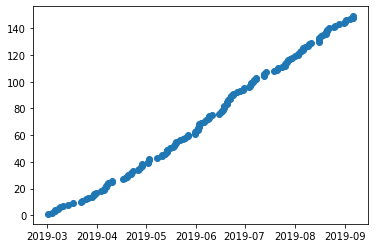

In [40]:
plt.plot_date(x=dates,y=cum_hits,xdate=True)

## Person.plays
It would be nice to have a person.plays method. I think it would require a PersonPlaysLink table 

## Relevent Stats
- a method on a person instance that takes in a game
- determines whether a player is a:
    - 1)pitcher 1a) starter 1b) bullpen 1c)length 
    - 2) hitter 2a) reg_hitter 3a) irr_hitter
- returns the relevent cumulative stats for that player

In [41]:
mike_trout_id

545361

In [42]:
most_recent_game = session.query(Game).order_by(Game.dateTime.desc()).first()

In [43]:
mike_trout_person = session.query(Person).filter(Person.id==mike_trout_id).one()

In [44]:
mike_trout_person.primaryPosition_type

'Outfielder'

In [45]:
query = session.query(Game,Play).\
                filter(Game.id==Play.game_id).\
                filter(and_(Game.type=='R',Game.dateTime<datetime.today())).\
                filter(Play.batter_id==mike_trout_id).\
                all()[:50]


In [65]:
{x[0] for x in query}

{<Game(pk='564734',id='2019/04/04/texmlb-anamlb-1')>,
 <Game(pk='564735',id='2019/04/05/texmlb-anamlb-1')>,
 <Game(pk='564736',id='2019/04/06/texmlb-anamlb-1')>,
 <Game(pk='564737',id='2019/04/07/texmlb-anamlb-1')>,
 <Game(pk='564738',id='2019/04/08/milmlb-anamlb-1')>,
 <Game(pk='564739',id='2019/04/09/milmlb-anamlb-1')>,
 <Game(pk='566086',id='2019/03/28/anamlb-oakmlb-1')>,
 <Game(pk='566087',id='2019/03/29/anamlb-oakmlb-1')>,
 <Game(pk='566088',id='2019/03/30/anamlb-oakmlb-1')>,
 <Game(pk='566089',id='2019/03/31/anamlb-oakmlb-1')>,
 <Game(pk='566376',id='2019/04/01/anamlb-seamlb-1')>,
 <Game(pk='566377',id='2019/04/02/anamlb-seamlb-1')>,
 <Game(pk='566772',id='2019/04/15/anamlb-texmlb-1')>}

In [47]:
[item for sublist in query for item in sublist]

[<Game(pk='566086',id='2019/03/28/anamlb-oakmlb-1')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='1')>,
 <Game(pk='566086',id='2019/03/28/anamlb-oakmlb-1')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='24')>,
 <Game(pk='566086',id='2019/03/28/anamlb-oakmlb-1')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='40')>,
 <Game(pk='566086',id='2019/03/28/anamlb-oakmlb-1')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='56')>,
 <Game(pk='566087',id='2019/03/29/anamlb-oakmlb-1')>,
 <Play(game_id='2019/03/29/anamlb-oakmlb-1',atBatIndex='1')>,
 <Game(pk='566087',id='2019/03/29/anamlb-oakmlb-1')>,
 <Play(game_id='2019/03/29/anamlb-oakmlb-1',atBatIndex='20')>,
 <Game(pk='566087',id='2019/03/29/anamlb-oakmlb-1')>,
 <Play(game_id='2019/03/29/anamlb-oakmlb-1',atBatIndex='37')>,
 <Game(pk='566087',id='2019/03/29/anamlb-oakmlb-1')>,
 <Play(game_id='2019/03/29/anamlb-oakmlb-1',atBatIndex='56')>,
 <Game(pk='566087',id='2019/03/29/anamlb-oakmlb-1')>,
 <Play(game_

In [68]:
play_events

['Double',
 'Hit By Pitch',
 'Strikeout',
 'Lineout',
 'Home Run',
 'Flyout',
 'Groundout',
 'Single',
 'Pop Out',
 'Forceout',
 'Field Error',
 'Double Play',
 'Sac Fly',
 'Walk',
 'Bunt Groundout',
 'Triple',
 'Grounded Into DP',
 'Caught Stealing 2B',
 'Sac Bunt',
 'Strikeout Double Play',
 'Catcher Interference',
 'Fielders Choice',
 'Fielders Choice Out',
 'Runner Out',
 'Batter Interference',
 'Fan Interference',
 'Intent Walk',
 'Sac Fly Double Play',
 'Pickoff 1B',
 'Bunt Pop Out',
 'Pickoff Caught Stealing 2',
 'Caught Stealing Home',
 'Bunt Lineout',
 'Game Advisory',
 'Batter Out',
 'Pickoff Caught Stealing 3',
 'Caught Stealing 3B',
 'Pickoff Caught Stealing H',
 'Runner Double Play',
 'Pickoff 2B',
 'Wild Pitch',
 'Pickoff 3B',
 'Triple Play',
 'Sac Bunt Double Play',
 'Passed Ball',
 'Stolen Base 2B',
 'Pickoff Error 1B']

In [85]:
aaron_judge = session.query(Person).filter(Person.fullName=='Aaron Judge').one()
aaron_judge

<Person(nameSlug='aaron-judge-592450')>

In [114]:
# remember to add the self argument here when you're done testing 
def relevant_stats(self,game_record,limit=None):
    """
    Method of ther Person instance. Takes in a game record 
    """
    date=game_record.dateTime
    stat_line = {}
    if self.primaryPosition_type in ['Hitter','Outfielder','Infielder','Catcher']:
        query = session.query(Game,Play).\
                        filter(Game.id==Play.game_id).\
                        filter(and_(Game.type=='R',Game.dateTime<date)).\
                        filter(Play.batter_id==self.id).\
                        order_by(Game.dateTime.desc()).\
                        all()[:limit]
    if self.primaryPosition_type=='Pitcher':
        query = session.query(Game,Play).\
                        filter(Game.id==Play.game_id).\
                        filter(and_(Game.type=='R',Game.dateTime<date)).\
                        filter(Play.pitcher_id==self.id).\
                        order_by(Game.dateTime.desc()).\
                        all()[:limit]
    games={x[0] for x in query}
    plays=[x[1] for x in query]
    
    singles = [x for x in plays if x.event=='Single']
    doubles = [x for x in plays if x.event=='Double']
    triples = [x for x in plays if x.event=='Triple']
    home_runs = [x for x in plays if x.event=='Home Run']
    walks = [x for x in plays if x.event=='Walk']
    strikeouts = [x for x in plays if x.event=='Strikeout']
    HBP = [x for x in plays if x.event=='Hit By Pitch']
    GDP = [x for x in plays if x.event=='Grounded Into DP']
    IBB = [x for x in plays if x.event=='Intent Walk']
    sac = [x for x in plays if x.event in ['Sac Bunt','Sac Fly']]
    interference = [x for x in plays if x.event=='Catcher Interference']
    LO = [x for x in plays if x.event=='Lineout']
    PO = [x for x in plays if x.event=='Pop Out']
    FO = [x for x in plays if x.event=='Flyout']
    GO = [x for x in plays if x.event=='Groundout']
    
    stat_line['Position_type']=self.primaryPosition_type
    stat_line['games']=len(games)
    stat_line['PA'] = len(plays)
    stat_line['AB'] = len(plays)-len(walks)-len(HBP)-len(IBB)-len(sac)-len(interference)
    stat_line['hits']=len(singles)+len(doubles)+len(triples)+len(home_runs)
    stat_line['singles']=len(singles)
    stat_line['doubles']=len(doubles)
    stat_line['triples']=len(triples)
    stat_line['home_runs']=len(home_runs)
    stat_line['walks']=len(walks)
    stat_line['strikeouts']=len(strikeouts)
    stat_line['HBP']=len(HBP)
    stat_line['RBIs']=sum([x.rbi for x in plays])
    stat_line['GDP']=len(GDP)
    stat_line['IBB']=len(IBB)
    stat_line['sac']=len(sac)
    stat_line['LO']=len(LO)
    stat_line['PO']=len(PO)
    stat_line['FO']=len(FO)
    stat_line['GO']=len(GO)
        
    return stat_line

Person.relevant_stats = relevant_stats

In [115]:
aaron_judge.relevant_stats(most_recent_game)

{'Position_type': 'Outfielder',
 'games': 102,
 'PA': 447,
 'AB': 378,
 'hits': 103,
 'singles': 57,
 'doubles': 18,
 'triples': 1,
 'home_runs': 27,
 'walks': 60,
 'strikeouts': 141,
 'HBP': 3,
 'RBIs': 55,
 'GDP': 11,
 'IBB': 4,
 'sac': 1,
 'LO': 22,
 'PO': 4,
 'FO': 34,
 'GO': 50}

In [116]:
[len(list(x.players(session))) for x in most_recent_game.teams]

[32, 32]

In [117]:
for x in [x.players(session) for x in most_recent_game.teams]:
    df=pd.DataFrame.from_dict([y.relevant_stats(most_recent_game) for y in x])

In [118]:
# I want to be able to tune the limit argument as a hyperparameter of my model
# I think that means that this will be the first step of my pipeline 
def game_relevant_stats(session,gameTeam_record,limit=None):
    game_record = gameTeam_record.game
    stats = []
    for team in game_record.teams:
        stats_dicts = [player.relevant_stats(game_record,limit) for player in team.players(session)]
        for stats_dict in stats_dicts:
            if team.team_id==game_record.homeTeam_id:
                stats_dict['home']=1
            else:
                stats_dict['home']=-1
        stats.append(stats_dicts)
    return [item for sublist in stats for item in sublist]

In [119]:
game_dicts=game_relevant_stats(session,gameTeam_record_test)

In [120]:
game_df = pd.DataFrame.from_dict(game_dicts)
display(game_df)

,Position_type,games,PA,AB,hits,singles,doubles,triples,home_runs,walks,...,HBP,RBIs,GDP,IBB,sac,LO,PO,FO,GO,home
0,Pitcher,25,135,124,33,26,4,0,3,9,...,0,14,2,1,1,8,6,13,27,1
1,Outfielder,53,199,180,43,25,8,0,10,14,...,3,18,8,2,0,17,4,21,46,1
2,Outfielder,54,217,201,43,29,4,0,10,12,...,1,32,4,1,2,18,12,29,29,1
3,Pitcher,28,96,84,17,13,2,0,2,10,...,1,8,3,1,0,5,2,6,14,1
4,Outfielder,27,131,117,32,20,6,2,4,12,...,0,12,1,0,1,4,4,18,22,1
5,Infielder,52,225,195,48,34,9,1,4,24,...,3,11,3,2,1,12,5,38,33,1
6,Pitcher,23,77,63,18,11,4,0,3,10,...,2,12,4,1,1,7,3,5,15,1
7,Pitcher,11,235,213,55,29,11,1,14,16,...,2,28,3,2,2,12,11,30,38,1
8,Pitcher,24,110,101,24,12,8,0,4,6,...,0,10,1,2,1,9,8,10,11,1
9,Infielder,54,199,189,57,42,9,2,4,7,...,1,21,7,2,0,19,8,17,46,1


In [121]:
game_dicts

[{'Position_type': 'Pitcher',
  'games': 25,
  'PA': 135,
  'AB': 124,
  'hits': 33,
  'singles': 26,
  'doubles': 4,
  'triples': 0,
  'home_runs': 3,
  'walks': 9,
  'strikeouts': 27,
  'HBP': 0,
  'RBIs': 14,
  'GDP': 2,
  'IBB': 1,
  'sac': 1,
  'LO': 8,
  'PO': 6,
  'FO': 13,
  'GO': 27,
  'home': 1},
 {'Position_type': 'Outfielder',
  'games': 53,
  'PA': 199,
  'AB': 180,
  'hits': 43,
  'singles': 25,
  'doubles': 8,
  'triples': 0,
  'home_runs': 10,
  'walks': 14,
  'strikeouts': 32,
  'HBP': 3,
  'RBIs': 18,
  'GDP': 8,
  'IBB': 2,
  'sac': 0,
  'LO': 17,
  'PO': 4,
  'FO': 21,
  'GO': 46,
  'home': 1},
 {'Position_type': 'Outfielder',
  'games': 54,
  'PA': 217,
  'AB': 201,
  'hits': 43,
  'singles': 29,
  'doubles': 4,
  'triples': 0,
  'home_runs': 10,
  'walks': 12,
  'strikeouts': 55,
  'HBP': 1,
  'RBIs': 32,
  'GDP': 4,
  'IBB': 1,
  'sac': 2,
  'LO': 18,
  'PO': 12,
  'FO': 29,
  'GO': 29,
  'home': 1},
 {'Position_type': 'Pitcher',
  'games': 28,
  'PA': 96,
  'AB'

### Concatenate and average by team
- home_starter.stats
- home_bullpen.stats
- home_length_pitcers.stats 
etc.


In [132]:
def player_agg_stats(game_relevant_stats):
    player_dicts=[]
    for player in game_relevant_stats:
        player_dict = {}
        
        player_dict['PA_per_Game'] = player['PA']/player['games']
        player_dict['BA'] = player['hits']/player['AB']
        player_dict['OBP'] = (
                                (player['hits']+player['walks']+player['HBP']+player['IBB'])
                                /
                                (player['AB']+player['walks']+player['HBP']+player['IBB']+player['sac'])
                              )
        player_dict['SLG'] = (
                                ((player['singles']*1)+(player['doubles']*2)+
                                (player['triples']*1)+(player['home_runs']*1))
                                /
                                player['AB']
                              )
        player_dict['position'] = player['Position_type']
        player_dict['home'] = player['home']
        player_dicts.append(player_dict)
    return player_dicts

In [133]:
player_agg_dicts = player_agg_stats(game_dicts)
player_agg_dicts

[{'PA_per_Game': 5.4,
  'BA': 0.2661290322580645,
  'OBP': 0.31851851851851853,
  'SLG': 0.29838709677419356,
  'position': 'Pitcher',
  'home': 1},
 {'PA_per_Game': 3.7547169811320753,
  'BA': 0.2388888888888889,
  'OBP': 0.31155778894472363,
  'SLG': 0.2833333333333333,
  'position': 'Outfielder',
  'home': 1},
 {'PA_per_Game': 4.018518518518518,
  'BA': 0.21393034825870647,
  'OBP': 0.2626728110599078,
  'SLG': 0.23383084577114427,
  'position': 'Outfielder',
  'home': 1},
 {'PA_per_Game': 3.4285714285714284,
  'BA': 0.20238095238095238,
  'OBP': 0.3020833333333333,
  'SLG': 0.2261904761904762,
  'position': 'Pitcher',
  'home': 1},
 {'PA_per_Game': 4.851851851851852,
  'BA': 0.27350427350427353,
  'OBP': 0.3384615384615385,
  'SLG': 0.3247863247863248,
  'position': 'Outfielder',
  'home': 1},
 {'PA_per_Game': 4.326923076923077,
  'BA': 0.24615384615384617,
  'OBP': 0.3422222222222222,
  'SLG': 0.2923076923076923,
  'position': 'Infielder',
  'home': 1},
 {'PA_per_Game': 3.34782608

In [137]:
import numpy as np
def game_agg_stats(player_agg_stats_result):
    game={}
    
    home_hitter_BAs = [x['BA'] for x in player_agg_stats_result if x['position'] != 'Pitcher' and x['home']==1]
    game['home_hitter_BA_mean'] = np.mean(home_hitter_BAs)
    game['home_hitter_BA_std'] = np.std(home_hitter_BAs)
    
    away_hitter_BAs = [x['BA'] for x in player_agg_stats_result if x['position'] != 'Pitcher' and x['home']==-1]
    game['away_hitter_BA_mean'] = np.mean(away_hitter_BAs)
    game['away_hitter_BA_std'] = np.std(away_hitter_BAs)
    
    home_hitter_slg = [x['SLG'] for x in player_agg_stats_result if x['position']!='Pitcher' and x['home']==1]
    game['home_hitter_slg_mean'] = np.mean(home_hitter_slg)
    game['home_hitter_slg']
    return game

In [138]:
game = game_agg_stats(player_agg_dicts)
game

{'home_hitter_BA_mean': 0.24446256617036358,
 'home_hitter_BA_std': 0.03301312447488101,
 'away_hitter_BA_mean': 0.2626875802633617,
 'away_hitter_BA_std': 0.033642905203584594}